In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [96]:
df = pd.read_csv('data/Dataset_spine.csv')
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


<AxesSubplot:xlabel='Class_att', ylabel='count'>

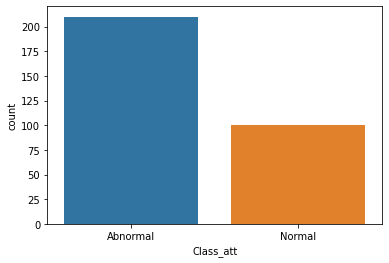

In [97]:
sns.countplot(x = 'Class_att', data=df)

In [98]:
# Mapping the classes
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [99]:
# Making Labels
X = df.iloc[:, 0:-2]
y = df.iloc[:, -2]

In [100]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [101]:
# Standardize Input
'''
The fit method is calculating the mean and variance of each of the features present in our data. 
The transform method is transforming all the features using the respective mean and variance.
Notice that in the test set, we use only transfor not fit, because we want to use mean and variance learned from the training set.
'''
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
# Define Parameters
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [103]:
## Train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



## Test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

In [104]:
# DataLoader
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TestData(torch.FloatTensor(X_test))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [105]:
# Simple Model
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [106]:
# CUDA Available on my machine
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [107]:
# Initiate the model and optimizers
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [108]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [109]:
# Train the model
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        print(f'Probability: {get_probability(y_pred)}')
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Probability: tensor([[0.7674],
        [0.3768],
        [0.6204],
        [0.7453],
        [0.5336],
        [0.4357],
        [0.4337],
        [0.4342],
        [0.6684],
        [0.4558],
        [0.3667],
        [0.3775],
        [0.4902],
        [0.7479],
        [0.4397],
        [0.3775],
        [0.4390],
        [0.5873],
        [0.3729],
        [0.4484],
        [0.5393],
        [0.5210],
        [0.5967],
        [0.1809],
        [0.2900],
        [0.4171],
        [0.5344],
        [0.4545],
        [0.4821],
        [0.5338],
        [0.5585],
        [0.4438],
        [0.3996],
        [0.3710],
        [0.3731],
        [0.3797],
        [0.4213],
        [0.5243],
        [0.4903],
        [0.5370],
        [0.6832],
        [0.5104],
        [0.6341],
        [0.5720],
        [0.4622],
        [0.4356],
        [0.4610],
        [0.4752],
        [0.4187],
        [0.3607],
        [0.5286],
        [0.3886],
        [0.4329],
        [0.4557],
        [0.5431

In [110]:
y_pred_list = []
y_prob_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_prob_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_prob_list = [a.squeeze().tolist() for a in y_prob_list]


In [112]:
results_df = pd.DataFrame()
results_df['GroundTruth'] = y_test
results_df['Prediction'] = y_pred_list
results_df['Confidence'] = y_prob_list

In [114]:
results_df.to_csv('data/prediction_results.csv')

In [94]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.62      0.65      0.63        31
           1       0.85      0.83      0.84        72

    accuracy                           0.78       103
   macro avg       0.74      0.74      0.74       103
weighted avg       0.78      0.78      0.78       103



TypeError: round(): argument 'input' (position 1) must be Tensor, not float